# Image Inpainting

---

Demonstrate image inpainting using a patch from one of Eli's Balåliden photos.


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from skimage.restoration import inpaint
from skimage.transform import rescale, resize

from util import imsave, imshow


---

## Inpainting explanation

As defined by Wikipedia, [image inpainting](https://en.wikipedia.org/wiki/Inpainting) is the process of reconstructing lost or deteriorated parts of images and videos. For my purpose, inpainting algorithms attempt to replace missing information in portions of an image obscured by a mask. What follows is a basic example, adapted from [the scikit-image docs](https://scikit-image.org/docs/dev/auto_examples/filters/plot_inpaint.html):

### Load an image

Load an image from disk. We will mask portions of it and try to inpaint them.


/home/matt/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


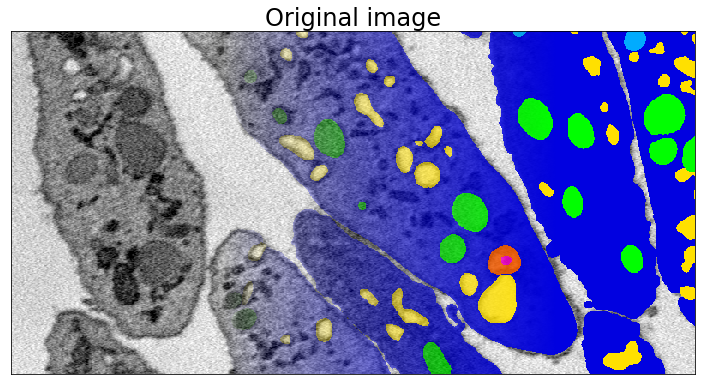

In [3]:
# Original, sharper image
# img = plt.imread('patch.png')

# Blurred, watercolor-like version
img = plt.imread('preview-wide.png')[..., :3]
img_mean = img.mean()

# Choose a figure size for display purposes
dpi = 84
fig_size = (img.shape[1] / dpi, img.shape[0] / dpi)

# Choose a resolution scale for the inpainted images. Small values will
# produce lower-resolution images, but more quickly
global_scale = 1
img_scaled = rescale(img, global_scale, anti_aliasing=True, multichannel=True)

imshow(img, fig_size)
_ = plt.title('Original image', fontsize=24)

### Create a mask

This defines the region in the image to be obscured.

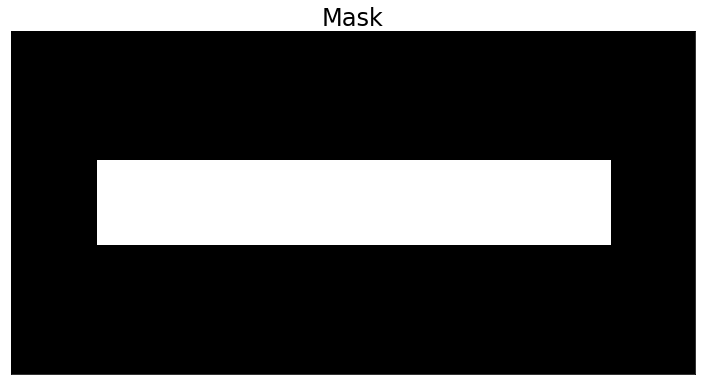

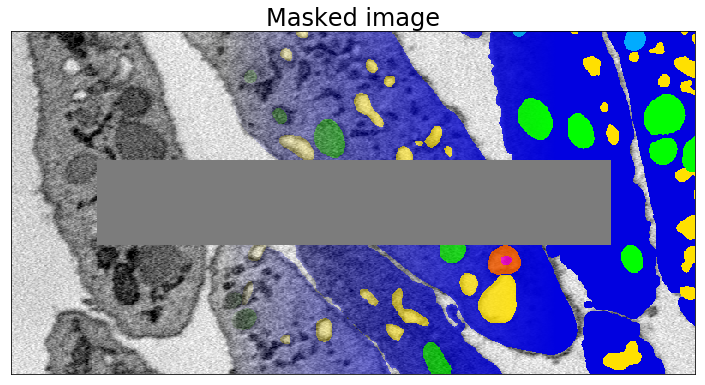

In [4]:
# Create a mask the same shape as the image
mask = np.zeros(img.shape[:-1])

# Create a bar blocking out the middle of the image
mask[150:250, 100:700] = 1

imsave(mask, cmap='gray')

imshow(mask, fig_size, cmap='gray')
_ = plt.title('Mask', fontsize=24)

# Show masked image
img_masked = img.copy()
img_masked[mask == 1, :] = img_mean

imshow(img_masked, fig_size)
_ = plt.title('Masked image', fontsize=24)

### Apply an inpainting algorithm

For this first experiment, I use scikit-image's `skimage.restoration.inpaint_biharmonic`, which uses a so-called [biharmonic inpainting method](https://arxiv.org/abs/1707.06567) to do the job.

In [ ]:
%%time

# Downsample images to go faster
scale = global_scale
if scale < 1:
    img_in = rescale(img_masked, scale, anti_aliasing=True, multichannel=True)
    mask_in = rescale(mask, scale, anti_aliasing=False, multichannel=False)
else:
    img_in = img_masked
    mask_in = mask

# Do the inpainting
img_inpainted = inpaint.inpaint_biharmonic(img_in, mask_in, multichannel=True)

imshow(img_inpainted, fig_size)
_ = plt.title('Inpainted image, biharmonic', fontsize=24)

imsave(img_inpainted)

The results are not that impressive, but that's ok. Improving the inpainting algorithm is a goal for the next stage of the project. We can turn any inpainting algorithm into an __extrapolation algorithm__.


---

## From inpainting to extrapolation

An inpainting algorithm operates on a masked image region, but nothing constrains a mask from obscuring an image border region.

### Example: Bottom border inpainted

In [ ]:
# Create a border mask

# Create a mask the same shape as the image
mask_border = np.zeros(img.shape[:-1])

# Create a bar blocking out the middle of the image
mask_border[-80:, :] = 1
imshow(mask_border, fig_size, cmap='gray')
_ = plt.title('Border mask', fontsize=24)

# Show masked image
img_masked_border = img.copy()
img_masked_border[mask_border == 1, :] = img_mean

imshow(img_masked_border, fig_size)
_ = plt.title('Masked border image', fontsize=24)

# Downsample images to go faster
scale = global_scale
if scale < 1:
    img_in = rescale(img_masked_border, scale, anti_aliasing=True, multichannel=True)
    mask_in = rescale(mask_border, scale, anti_aliasing=False)
else:
    img_in = img_masked_border
    mask_in = mask_border

# Do the inpainting
img_inpainted_border = inpaint.inpaint_biharmonic(img_in, mask_in, multichannel=True)

imshow(img_inpainted_border, fig_size)
_ = plt.title('Image, border inpainted', fontsize=24)

imsave(img_inpainted_border)

### Example: Border extrapolated (simple)

Instead of masking out an existing part of the border, create a new image containing everything plus an additional blank region around the edges.

In [5]:
def extrapolate_simple(image, bx, by, do_plots=False):
    img_new = -1 * np.ones((image.shape[0] + 2 * by, 
                            image.shape[1] + 2 * bx, 
                            image.shape[2]))
    img_new[by:(by + image.shape[0]), 
            bx:(bx + image.shape[1]),
            ...] = image

    fig_size_new = (img_new.shape[1] / (dpi * global_scale), 
                    img_new.shape[0] / (dpi * global_scale))

    mask_new = img_new[..., 0] == -1
    
    if do_plots:
        imshow(mask_new, fig_size_new, cmap='gray')
        _ = plt.title('Extended border mask', fontsize=24)

    img_new[img_new == -1] = 1

    if do_plots:
        imshow(img_new, fig_size_new)
        _ = plt.title('Image with extended border mask', fontsize=24)

    # Do the inpainting
    img_extrapolated_border = inpaint.inpaint_biharmonic(img_new, mask_new, multichannel=True)

    if do_plots:
        imshow(img_extrapolated_border, fig_size_new)
        _ = plt.title('Image, border extrapolated', fontsize=24)

    return img_extrapolated_border



# img_extrapolated_border = extrapolate_simple(img_scaled, 25, 25, do_plots=True)
# imsave(img_extrapolated_border)

### Example: Border extrapolated (recursive)
Instead of inpainting a large border region once, one could also recursively inpaint a small region multiple times. I wonder if it will look any different? Compare a 100 pixel simple extrapolation with a 10-fold 10 pixel recursive extrapolation.

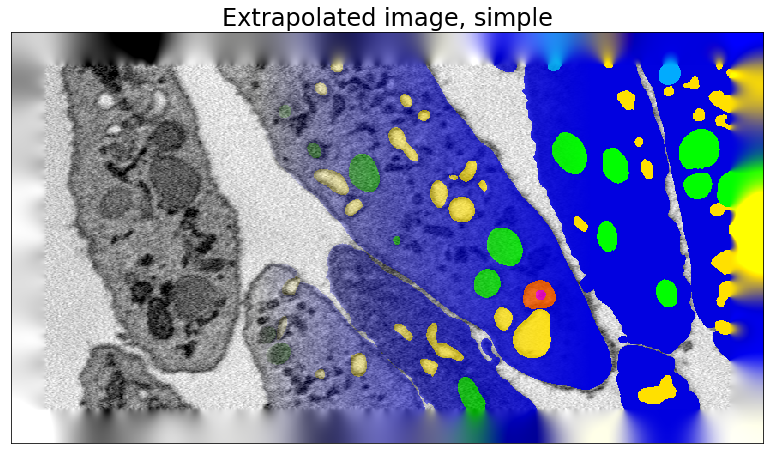

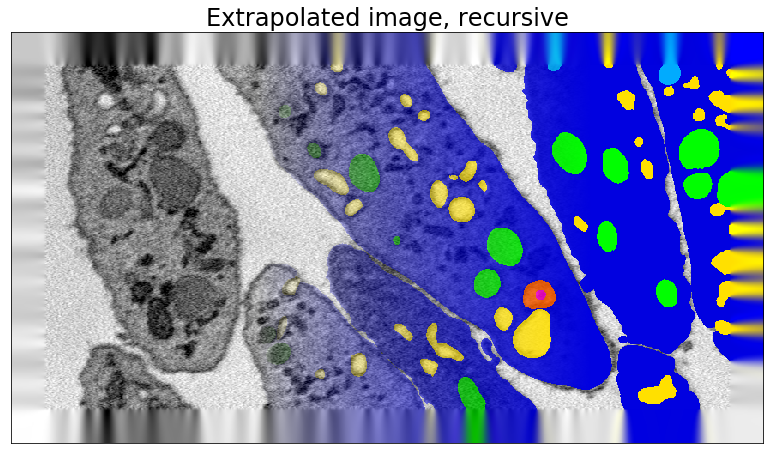

In [6]:
def extrapolate_recursive(image, bx, by, n):
    for i in range(n):
        image = extrapolate_simple(image, bx, by)
    
    return image
    
img_extrapolated_simple = extrapolate_simple(img_scaled, 40, 40, do_plots=False)
fig_size = (img_extrapolated_simple.shape[1] / (dpi * global_scale), 
            img_extrapolated_simple.shape[0] / (dpi * global_scale))

imshow(img_extrapolated_simple, fig_size)
_ = plt.title('Extrapolated image, simple', fontsize=24)

imsave(img_extrapolated_simple)

img_extrapolated_recursive = extrapolate_recursive(img_scaled, 4, 4, 10)
imshow(img_extrapolated_recursive, fig_size)
_ = plt.title('Extrapolated image, recursive', fontsize=24)

imsave(img_extrapolated_recursive)